# Notebook de test des données lapi post-traitees

In [329]:
%load_ext autoreload
%autoreload 
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\Martin_Perso')
import Connexion_Transfert as ct
import donnees_posttraitees as t
import graphs as g
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import datetime as dt
#pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 50)
alt.data_transformers.enable('default', max_rows=None)
import os, math, re
from sklearn.cluster import DBSCAN
from sklearn import svm,datasets
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. import des données, traitement de mise en forme
## 1.1 Import
Les données sont importées sur la période du 24/01/19 au 23/02/19, sur laquelle il n'y a pas de manque de données à priori

In [2]:
%time df_passages_source, df_plaques, df_immat=t.ouvrir_fichier_lapi_final('2019-01-23 00:00:00','2019-02-13 23:59:59')

Wall time: 28min 39s


In [ ]:
#export au format svg des données TV
for i in range(1,20) :
    chemin=os.path.join(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\graphs\nb_veh_J_cam',f'cam{i}.svg')
    g.graph_nb_veh_jour_camera_multi_j(df_passages,'2019-01-23 00:00:00','2019-01-23 23:59:59',i,22).save(chemin)

## 1.3 Ajout de l'attribut de différenciation VL / PL

In [3]:
%time df_passages2=t.affecter_type(df_passages_source,df_immat)

Wall time: 3min 48s


In [4]:
%time df_passages3=t.affecter_type_nuit(df_passages2,df_immat)

Wall time: 35.6 s


### différenciation VL / PL

In [5]:
df_passages_pl=df_passages3.loc[df_passages3['l']==1].copy()
df_passages_vl=df_passages3.loc[df_passages3['l']==0].copy()

## 1.2. Suppression des doublons

### 1.2.1 Doublons

In [6]:
%%time 
df_passages_pl_ss_doublons=t.supprimer_doublons(df_passages_pl)
df_passages_vl_ss_doublons=t.supprimer_doublons(df_passages_vl)

Wall time: 38.2 s


### 1.2.2 passages proches

In [ ]:
#pour visu
%time groupe_pl_rappro, groupe_pl=t.passages_proches(df_passages_pl_ss_doublons)
jointure = g.analyse_passage_proches(groupe_pl_rappro, groupe_pl)
g.graph_passages_proches(jointure, groupe_pl_rappro)

In [7]:
%%time 
#pour traitement
passg_pl_recale_cam10=t.recalage_cam10(df_passages_pl_ss_doublons)
passg_vl_recale_cam10=t.recalage_cam10(df_passages_vl_ss_doublons)

Wall time: 5min 28s
Parser   : 101 ms


## 1.4. Filtre des immatriculations non cohérentes

In [8]:
%%time 
df_passages_immat_ok, df_immat_suppr=t.filtre_plaque_non_valable(passg_pl_recale_cam10, df_plaques)
df_passages_immat_vl_ok, df_immat_suppr=t.filtre_plaque_non_valable(passg_vl_recale_cam10, df_plaques)

Wall time: 19min 37s


## 1.5 Nombre de PL / jour / camera
> Utile pour comparer avec les données gestionnaire, voir avec Gille si donnes de gestionnaires mises en forme

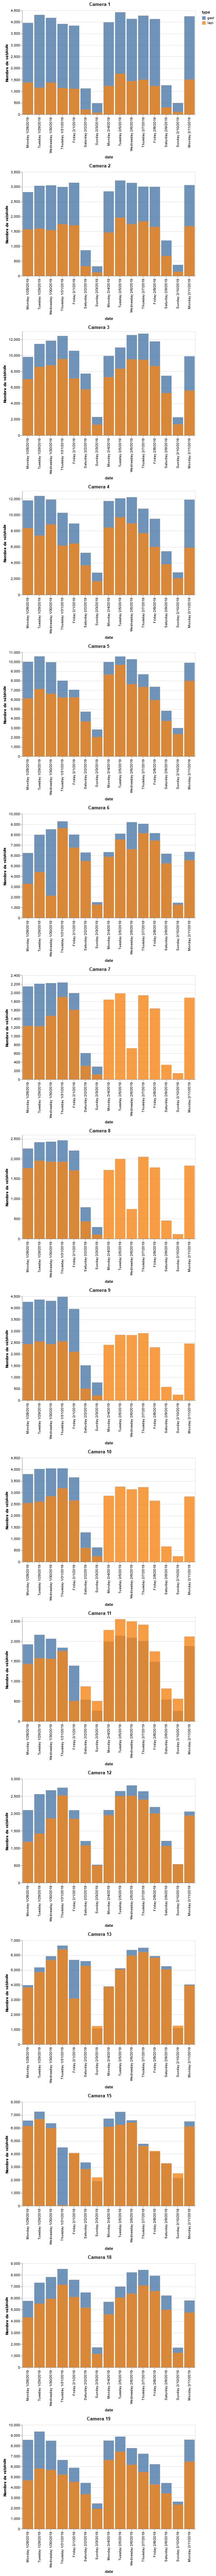

In [330]:
#comparaison des données sur une camera
g.comp_lapi_gest_multicam(df_passages_immat_ok,t.donnees_gest)

# 2. Identifier les trajets de transit

In [9]:
dico_od,  dico_passag, dico_tps_max=t.transit_temps_complet('2019-01-23 00:00:00',22,df_passages_immat_ok)

date : 2019-01-23 00:00:00 debut_traitement : 2019-06-15 21:35:36.325325
date : 2019-01-24 00:00:00 debut_traitement : 2019-06-15 21:36:31.374768
date : 2019-01-25 00:00:00 debut_traitement : 2019-06-15 21:37:26.174376
date : 2019-01-26 00:00:00 debut_traitement : 2019-06-15 21:38:20.520978
date : 2019-01-27 00:00:00 debut_traitement : 2019-06-15 21:39:07.134983
date : 2019-01-28 00:00:00 debut_traitement : 2019-06-15 21:39:44.844866
date : 2019-01-29 00:00:00 debut_traitement : 2019-06-15 21:40:49.564056
date : 2019-01-30 00:00:00 debut_traitement : 2019-06-15 21:42:04.405831
date : 2019-01-31 00:00:00 debut_traitement : 2019-06-15 21:43:20.512928
date : 2019-02-01 00:00:00 debut_traitement : 2019-06-15 21:44:43.368445
date : 2019-02-02 00:00:00 debut_traitement : 2019-06-15 21:46:16.330933
date : 2019-02-03 00:00:00 debut_traitement : 2019-06-15 21:47:43.794770
date : 2019-02-04 00:00:00 debut_traitement : 2019-06-15 21:48:56.949413
date : 2019-02-05 00:00:00 debut_traitement : 2019-

# 3. Filtrer les trajets selon un temps de parcours

## 3.1 Dataframe des temps de parcours de base

In [10]:
%time dixco_tpsmax_corrige=t.corriger_df_tps_parcours(dico_tps_max)

Wall time: 2.48 s


## 3.2 Identification du trafic de transit sans marge

In [11]:
#affectation des temps de parcours de reference
%time df_transit_tps_ref=t.jointure_temps_reel_theorique(dico_od,dixco_tpsmax_corrige,t.liste_complete_trajet)

Wall time: 2min 14s


In [12]:
#df des transit avec marge 0 ss extrapolation
%time df_transit_marge0_ss_extrapolation=t.identifier_transit(df_transit_tps_ref, 0)

Wall time: 21.5 s


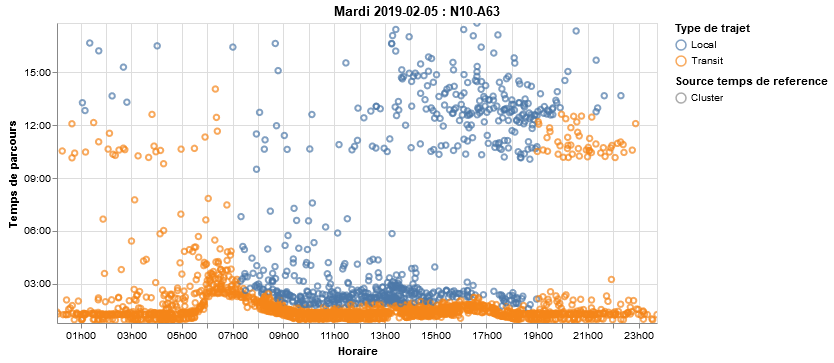

In [142]:
g.graph_transit_filtre(df_transit_marge0_ss_extrapolation,'2019-02-05 00:00:00', '2019-02-05 23:59:59','N10-A63')

## 3.3 Extrapolation pour recuperer les trajets manquants 

In [14]:
%%time
liste_od_ok=['A660-A62','A62-A63','A63-A62','A62-A10','A660-N10', 'A660-A10','N10-A63','A62-N10']
df_transit_extrapole=df_transit_marge0_ss_extrapolation.copy()
for od in [x for x in  df_transit_marge0_ss_extrapolation.o_d.unique().tolist() if x not in liste_od_ok ] : 
    for date in set([a[0].strftime('%Y-%m-%d') for a in t.creer_liste_date('2019-01-23',22)]):
            try : 
                 df_transit_extrapole=t.predire_type_trajet(df_transit_extrapole, od,date,600,35)
            except ValueError : 
                continue

Wall time: 6min 36s


***exemple d'impact de l'extrapolation***

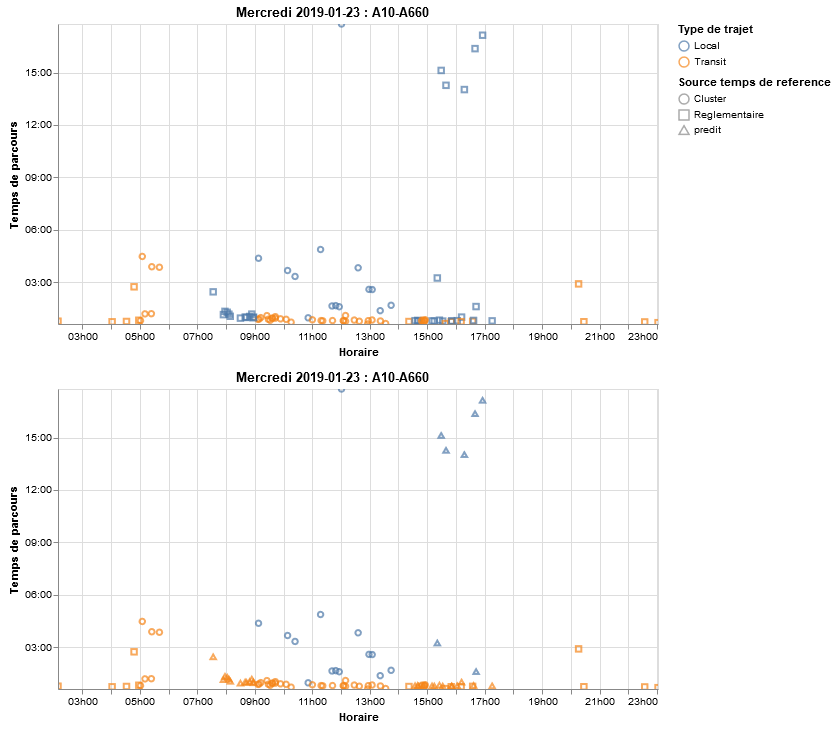

In [191]:
alt.vconcat(g.graph_transit_filtre_multiple(dico_df_transit['df_transit_marge0'],'2019-01-23 00:00:00', '2019-01-23 23:59:59','A10-A660', 1),
g.graph_transit_filtre_multiple(df_transit_extrapole,'2019-01-23 00:00:00', '2019-01-23 23:59:59','A10-A660', 1))            

***modification du dico des temps max avec ajout des temps de référence issu de l'extrapolation***

In [15]:
#localiser les periodes et o-d avec un temps de référence modifié
%time dixco_tpsmax_corrige=t.corriger_tps_parcours_extrapole(dixco_tpsmax_corrige,df_transit_extrapole)

Wall time: 1.2 s


## 3.4 Prendre en compte les aires entre Cestas et A63
> L'idée est que si le PL fait un trajet depuis ou vers A63 et qu'il est vu à Cestas, alors on va prendre en compte comm etemps de référence le temps entre Cestas et la l'entrée ou la sortuie du dispositif LAPI, pour s'abroger des temps de pause sur les grosses aires de A63

In [16]:
#creation des attributs relatifs a Cestas, pour les PL sur une O-D liées à A63, non identifiés comme transit, et qui ont été vus à Cestas
%time df_transit_A63_redresse=t.correction_temps_cestas(df_transit_extrapole,df_passages_immat_ok,dixco_tpsmax_corrige)

Wall time: 1min 50s


## 3.5 appliquer une marge 

In [17]:
%%time
#appliquer la martge sur les donnees issu de l'extrapolation et sur celle issues de la prise ene compte des aires
dico_df_transit={}
for i in [0,15,30,45,60,90] :
    dico_df_transit['df_transit_extrapole_marge'+str(i)]=t.identifier_transit(df_transit_extrapole, i)
    dico_df_transit['df_transit_airesA63_marge'+str(i)]=t.identifier_transit(df_transit_A63_redresse, i,'temps_filtre_cestas','tps_parcours_cestas')
#mettre en forme les données de prise en compte des aires
for i in [0,15,30,45,60,90] :
    dico_df_transit['df_transit_airesA63_marge'+str(i)]=t.forme_df_cestas(dico_df_transit['df_transit_airesA63_marge'+str(i)])
#concatener les 2 donnees
for i in [0,15,30,45,60,90] :
    dico_df_transit['df_transit_marge'+str(i)]=pd.concat([dico_df_transit['df_transit_airesA63_marge'+str(i)],
                                                         dico_df_transit['df_transit_extrapole_marge'+str(i)]],sort=False)
#remplir les valeurs NaN de correction_o_d
for i in [0,15,30,45,60,90] :
    dico_df_transit['df_transit_marge'+str(i)].correction_o_d=(dico_df_transit['df_transit_marge'+str(i)].
                                                               correction_o_d.fillna(False).copy())

Wall time: 2min 37s
Parser   : 109 ms


In [90]:
#exemple de visu sur 3 semaines
for od in dico_df_transit['df_transit_marge0'].o_d.unique(): 
    for i in [0,15,30,45,600] :
        nom_chemin=r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\graphs\transit_J_OD\marge_'+str(i)+'_min'
        chemin=os.path.join(nom_chemin,f'{od}.svg')
        g.graph_transit_filtre_multiple(dico_df_transit['df_transit_marge'+str(i)],'2019-01-23 00:00:00', '2019-01-23 23:59:59',od, 22).save(chemin)

***Impact de la marge***

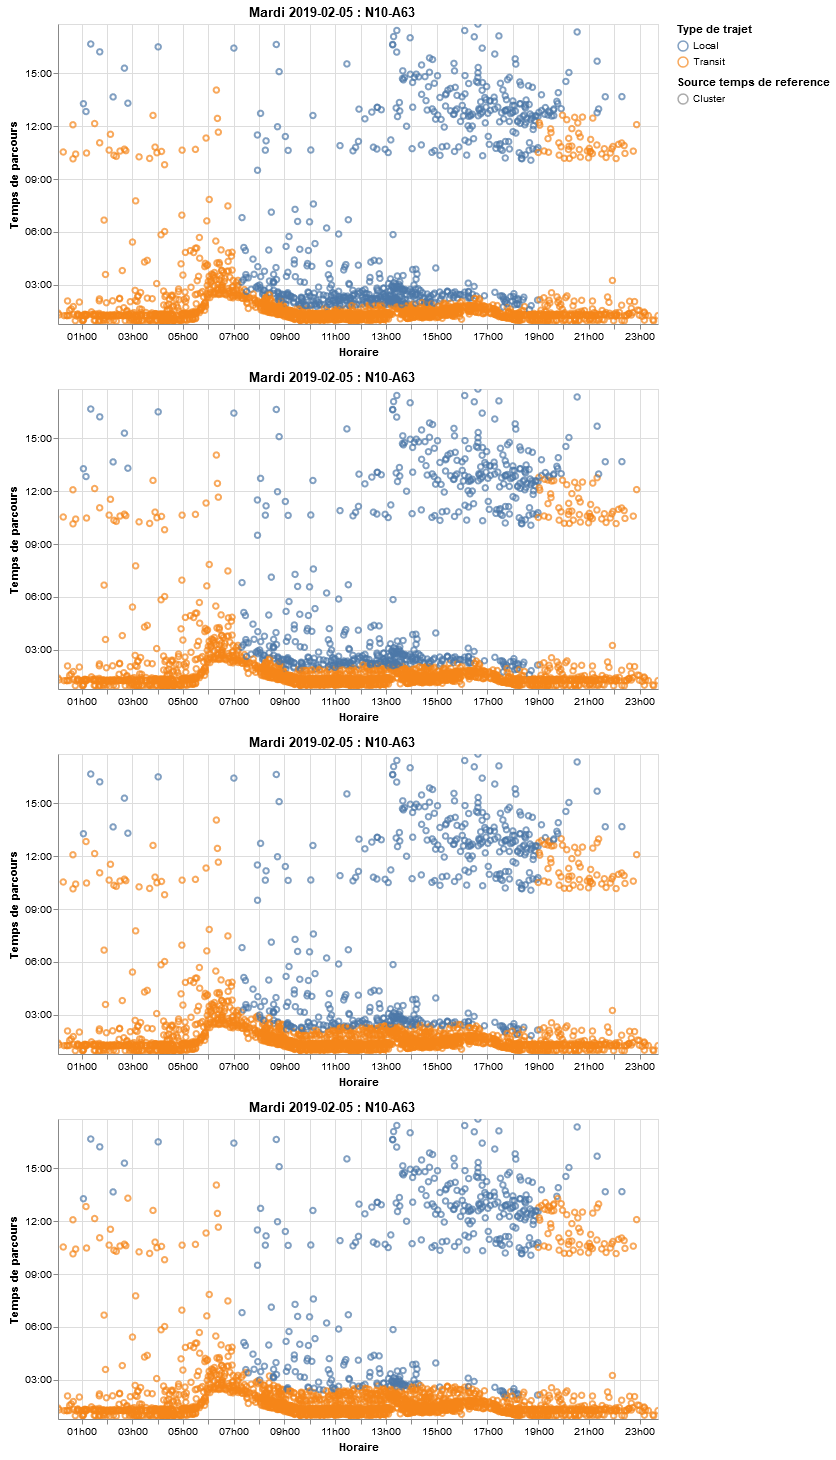

In [139]:
alt.vconcat(g.graph_transit_filtre(dico_df_transit['df_transit_marge0'],'2019-02-05 00:00:00', '2019-02-05 23:59:59','N10-A63'),
            g.graph_transit_filtre(dico_df_transit['df_transit_marge15'],'2019-02-05 00:00:00', '2019-02-05 23:59:59','N10-A63'),
            g.graph_transit_filtre(dico_df_transit['df_transit_marge30'],'2019-02-05 00:00:00', '2019-02-05 23:59:59','N10-A63'),
            g.graph_transit_filtre(dico_df_transit['df_transit_marge45'],'2019-02-05 00:00:00', '2019-02-05 23:59:59','N10-A63'))

***Filtre des données***

In [37]:
%%time
dico_df_od_ok={'df_od_ok_marge'+str(i):dico_df_transit['df_transit_marge'+str(i)].loc[dico_df_transit['df_transit_marge'+str(i)]['filtre_tps']==1]
         for i in [0,15,30,45,60,90]}
#dico_df_passag_ok={'df_passag_ok_marge'+str(i):t.trajet2passage(dico_df_od_ok['df_od_ok_marge'+str(i)],dico_passag) for i in [0,15,30,45,600]}

Wall time: 5.51 s


# 4. Correction des trajets depuis ou vers A660 relatifs à A63

In [21]:
%%time 
#recuperer les passages correspondant aux trajets identifies
dico_passag_avantcorr={'passag_avantcorr'+str(i):
                   t.trajet2passage(dico_df_od_ok ['df_od_ok_marge'+str(i)],df_passages_immat_ok) 
                   for i in [0,15,30,45,60,90]}

Wall time: 1h 53min 26s
Compiler : 156 ms


In [47]:
%%time 
dico_corr_A63_A660={'corr_A63_A660'+str(i):
                    t.correction_trajet(df_passages_immat_ok, dico_df_od_ok ['df_od_ok_marge'+str(i)])
                    for i  in [0,15,30,45,60,90]}

Wall time: 5h 42min
Compiler : 158 ms


# 5. Extrapolation des trajets non complets

In [49]:
dico_df_od_final={}

In [139]:
%%time
for i  in [0,15,30,45,60,90]:
    df_filtre_A63,df_passage_transit,df_non_transit=(t.param_trajet_incomplet('2019-01-23 00:00:00',
        dico_corr_A63_A660['corr_A63_A660'+str(i)],df_passages_immat_ok,
        dico_passag_avantcorr['passag_avantcorr'+str(i)]))
    trajet_transit_incomplet2, passage2=t.transit_trajet_incomplet(df_filtre_A63,df_passage_transit,'2019-01-23 00:00:00',22, df_passages_immat_ok)
    #affectation des temps de parcours de reference
    df_transit_incomplet_tps_ref=t.jointure_temps_reel_theorique(trajet_transit_incomplet2,dixco_tpsmax_corrige,t.liste_trajet_incomplet,'incomplet')
    #Maj de l'attruibut drapeau et Maj des autres attruibuts
    df_transit_incomplet_tps_ref=t.identifier_transit(df_transit_incomplet_tps_ref, 0)
    #mettre en forme les attributs
    df_transit_incomplet_tps_ref=df_transit_incomplet_tps_ref[['date_cam_1', 'immat', 'state', 'l', 'date_cam_2', 'cameras', 'origine',
           'destination', 'o_d', 'tps_parcours', 'period', 'date', 'temps', 'type',
           'tps_parcours_theoriq','temps_filtre', 'filtre_tps']]
    #filtrer le df : 
    df_transit_incomplet_tps_ref_final=df_transit_incomplet_tps_ref.loc[df_transit_incomplet_tps_ref['filtre_tps']==1].copy()
    #ajouter l'attribut d'identification des trajets 
    df_transit_incomplet_tps_ref_final['correction_o_d']=True
    df_transit_incomplet_tps_ref_final['correction_o_d_type']='extrapole'
    #6. Ajouter au df des o_d précédents : 
    dico_df_od_final['df_od_final_marge'+str(i)]=pd.concat([dico_corr_A63_A660['corr_A63_A660'+str(i)],df_transit_incomplet_tps_ref_final],sort=False)

date : 2019-01-23 00:00:00 debut_traitement : 2019-06-17 16:49:35.619548
date : 2019-01-24 00:00:00 debut_traitement : 2019-06-17 17:19:27.937375
date : 2019-01-25 00:00:00 debut_traitement : 2019-06-17 17:27:51.460346
date : 2019-01-26 00:00:00 debut_traitement : 2019-06-17 17:34:29.804715
date : 2019-01-27 00:00:00 debut_traitement : 2019-06-17 17:39:19.518061
date : 2019-01-28 00:00:00 debut_traitement : 2019-06-17 17:41:40.235129
date : 2019-01-29 00:00:00 debut_traitement : 2019-06-17 17:47:12.454157
date : 2019-01-30 00:00:00 debut_traitement : 2019-06-17 17:52:25.552646
date : 2019-01-31 00:00:00 debut_traitement : 2019-06-17 17:58:19.438387
date : 2019-02-01 00:00:00 debut_traitement : 2019-06-17 18:01:41.578445
date : 2019-02-02 00:00:00 debut_traitement : 2019-06-17 18:04:43.457625
date : 2019-02-03 00:00:00 debut_traitement : 2019-06-17 18:07:13.406805
date : 2019-02-04 00:00:00 debut_traitement : 2019-06-17 18:08:51.008896
date : 2019-02-05 00:00:00 debut_traitement : 2019-

KeyboardInterrupt: 

In [145]:
#sauvegarder les resultats
for i in [0,15,30]:
    nomfichier=f'marge{i}min.json'
    dico_df_od_final['df_od_final_marge'+str(i)].reset_index().drop(['level_0','index'],axis=1).to_json(
        os.path.join(r'C:\Users\martin.schoreisz\Desktop\LAPI_LOCAL\donnees_verif_fiabilite',nomfichier),orient='index')

# 6. Créer les tableaux de matrice o_d

## 6.1 Resultats

### 6.1.1 Nb total de veh sur la periode

In [114]:
# dico des o-d nombre total
dico_mat_od={'mat_od_marge'+str(i):pd.pivot_table(dico_df_od_ok['df_od_ok_marge'+str(i)],values='l', index='origine', 
                                                  columns='destination',aggfunc='count', margins=True).fillna('NC') for i in [0,15,30,45,600]}

In [130]:
mat_od_tot=pd.pivot_table(dico_df_od_final['df_od_final_marge45'],values='l', index='origine', 
                                                  columns='destination',aggfunc='count', margins=True).fillna('NC')
mat_od_tot_calcul=pd.pivot_table(dico_df_od_final['df_od_final_marge45'],values='l', index='origine', 
                                                  columns='destination',aggfunc='count').fillna('NC')
mat_od_tot

destination    A10    A62    A63  A660   A89    N10     All
origine                                                    
A10             NC   5972  12453  1809   332     NC   20566
A62           6105     NC    798  1027  1058   7298   16286
A63          11996    495     NC    NC  2975  57743   73209
A660          1572    868     NC    NC   964   5147    8551
A89            299    966   4046  1292    NC     NC    6603
N10             NC   4767  47329  4629    NC     NC   56725
All          19972  13068  64626  8757  5329  70188  181940

### 6.1.2 mjo, mjo+samedi, mja

Pour faire du MJO il faut connaitre les dates à enlever de certaines O-D car il ya des trous dans les données, cf Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\donnees_verif_fiabilite\Synthese_absence_donnees.ods

depuis N10 : supprimer les 29/01 et 30/01<br>vers A10 supprimer le 01/02<br>vers A62 supprimer le 24/01<br>depuis A63 supprimer le 31/01<br>depuis A89 supprimer le 06/02<br>vers A89 supprimer le 06/02

In [117]:
# filtre des dates selon les jours indisponible pour supprimer tout la journee
df_transit_jo=dico_df_od_final['df_od_final_marge45'].loc[dico_df_od_final['df_od_final_marge45'].apply(lambda x : 
not (x['cameras'][0]==6 and (x['date_cam_1'].day==pd.to_datetime('2019-01-29').day or x['date_cam_1'].day==pd.to_datetime('2019-01-30').day)) and 
not (x['cameras'][-1]==11 and x['date_cam_1'].day==pd.to_datetime('2019-02-01').day) and 
not (x['cameras'][-1]==9 and x['date_cam_1'].day==pd.to_datetime('2019-01-24').day) and
not (x['cameras'][0]==15 and x['date_cam_1'].day==pd.to_datetime('2019-01-31').day) and 
not (x['cameras'][-1]==7 and x['date_cam_1'].day==pd.to_datetime('2019-02-06').day) and 
not (x['cameras'][0]==8 and x['date_cam_1'].day==pd.to_datetime('2019-02-06').day),axis=1)]
#filtre des dates pour supprimer les WE
df_transit_jo=df_transit_jo.loc[df_transit_jo.set_index('date_cam_1').index.dayofweek<5]

In [128]:
#matrice_o_d jours ouvres
mat_o_d_jo_marge45=round(pd.pivot_table(df_transit_jo,values='l', index='origine', columns='destination',aggfunc='count')/t.matrice_nb_jo,0)
mat_o_d_jo_marge45

In [129]:
pd.pivot_table(df_transit_jo,values='l', index='origine', columns='destination',aggfunc='count')

destination     A10     A62      A63    A660     A89      N10
origine                                                      
A10             NaN  5277.0  10189.0  1528.0   301.0      NaN
A62          5545.0     NaN    765.0   995.0   976.0   6991.0
A63          9765.0   447.0      NaN     NaN  2577.0  46931.0
A660         1346.0   798.0      NaN     NaN   885.0   4588.0
A89           267.0   822.0   3491.0  1159.0     NaN      NaN
N10             NaN  3981.0  34530.0  3661.0     NaN      NaN

## 6.2 Illsutrations impacts des paramètres

### 6.2.1 Impact methode de prediction sur marge0

In [160]:
pd.pivot_table(dico_extrapole_prediction['marge15'].loc[dico_extrapole_prediction['marge15']['filtre_tps']==1],values='l', index='origine', 
                                                  columns='destination',aggfunc='count', margins=True).fillna('NC')

destination    A10    A62    A63   A660   A89    N10     All
origine                                                     
A10             NC   5643   8459   2469   341     NC   16912
A62           5489     NC    362   1100  1015   6909   14875
A63           8002    266     NC     NC  2031  41587   51886
A660          2093    834     NC     NC  1129   8239   12295
A89            292    937   2924   1551    NC     NC    5704
N10             NC   4536  34111   7461    NC     NC   46108
All          15876  12216  45856  12581  4516  56735  147780

### 6.2.2 Impact redressement vaeurs A63 et A660

In [173]:
# donnees de base
pl_transit_base=df_transit_marge0_ss_extrapolation.loc[df_transit_marge0_ss_extrapolation['filtre_tps']==1].copy()

In [175]:
pd.pivot_table(pl_transit_base, values='l',index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination    A10    A62    A63   A660   A89    N10     All
origine                                                     
A10             NC   5265   7658   1954   182     NC   15059
A62           5183     NC    306    740   734   6664   13627
A63           7400    202     NC     NC  1654  39887   49143
A660          1869    577     NC     NC   784   7882   11112
A89            207    659   2340   1125    NC     NC    4331
N10             NC   4143  32739   7086    NC     NC   43968
All          14659  10846  43043  10905  3354  54433  137240

In [169]:
# donnees redressee
pd.pivot_table(df_od_corrige,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination    A10    A62    A63   A660   A89    N10     All
origine                                                     
A10             NC   5265   7666   1946   182     NC   15059
A62           5183     NC    332    714   734   6664   13627
A63           7760    233     NC     NC  1767  40181   49941
A660          1509    546     NC     NC   671   7588   10314
A89            207    659   2402   1063    NC     NC    4331
N10             NC   4143  32839   6986    NC     NC   43968
All          14659  10846  43239  10709  3354  54433  137240

### 6.2.3 impact trajets non complet

In [272]:
pd.pivot_table(df_od_final,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination    A10    A62    A63   A660   A89    N10     All
origine                                                     
A10             NC   5298   7666   1946   182     NC   15092
A62           5183     NC    332    714   741   6692   13662
A63           7760    235     NC     NC  1777  40482   50254
A660          1509    546     NC     NC   671   7588   10314
A89            207    665   2402   1063    NC     NC    4337
N10             NC   4158  32839   6986    NC     NC   43983
All          14659  10902  43239  10709  3371  54762  137642

### 6.2.4 impact prise en compte aires

In [136]:
dico_df_transit['df_transit_extrapole_marge0'].loc[dico_df_transit['df_transit_extrapole_marge0']['filtre_tps']==1].pivot_table(
    values='l', index='origine', columns='destination',aggfunc='count').fillna('NC')

destination   A10   A62    A63  A660   A89    N10
origine                                          
A10            NC  5265   7658  1954   182     NC
A62          5183    NC    306   740   734   6664
A63          7400   202     NC    NC  1654  39887
A660         1869   577     NC    NC   784   7882
A89           207   659   2340  1125    NC     NC
N10            NC  4143  32739  7086    NC     NC

In [137]:
dico_df_transit['df_transit_airesA63_marge0'].loc[dico_df_transit['df_transit_extrapole_marge0']['filtre_tps']==1].pivot_table(
    values='l', index='origine', columns='destination',aggfunc='count').fillna('NC')

destination   A10  A62   A63  A89   N10
origine                                
A10            NC   NC  2336   NC    NC
A62            NC   NC   440   NC    NC
A63          2411  138    NC  474  7384
A89            NC   NC   772   NC    NC
N10            NC   NC  6874   NC    NC

# vérifications

In [299]:
# trouver les passages correspondants aux trajets
passages_transit=t.trajet2passage(df_od_final,df_passages_immat_ok)

In [327]:
#trouver les passages non compris dans passages transit
passages_non_transit=df_passages_immat_ok.loc[
    ~df_passages_immat_ok.reset_index().set_index(['created', 'camera_id','immat']).index.isin(
    passages_transit.set_index(['created', 'camera_id','immat']).index.tolist())]

In [328]:
passages_non_transit.reset_index().sort_values('created').groupby('plaque_ouverte').agg(
    {'camera_id':lambda x : tuple(x),
     'created':lambda x: tuple(x)})

In [ ]:
%time t.trajet_non_transit(df_od_final,df_passages_immat_ok)

In [330]:
df_passages_immat_ok.loc[df_passages_immat_ok['plaque_ouverte']=='ZV419CZ'].sort_index()

index  camera_id  \
created                                   
2019-01-23 14:57:44   549952          3   
2019-01-23 15:17:37  5796050         18   
2019-01-24 03:46:12  5805478         13   

                                                        immat  fiability    l  \
created                                                                         
2019-01-23 14:57:44  aa208dd1b76a8266c4fbcad5257ca301ee6a91fd         99  1.0   
2019-01-23 15:17:37  aa208dd1b76a8266c4fbcad5257ca301ee6a91fd         99  1.0   
2019-01-24 03:46:12  aa208dd1b76a8266c4fbcad5257ca301ee6a91fd         99  1.0   

                     state      id plaque_ouverte  \
created                                             
2019-01-23 14:57:44     SK  765103        ZV419CZ   
2019-01-23 15:17:37  IT/SK  765104        ZV419CZ   
2019-01-24 03:46:12     SK  765105        ZV419CZ   

                                                     chiffree  plaque_valide  
created                                                                       
2019-01-23 14:57:44  aa208dd1b76a8266c4fbcad5257ca301ee6a91fd           True  
2019-01-23 15:17:37  aa208dd1b76a8266c4fbcad5257ca301ee6a91fd           True  
2019-01-24 03:46:12  aa208dd1b76a8266c4fbcad5257ca301ee6a91fd           True

In [331]:
dico_od.loc[dico_od['plaque_ouverte']=='0011HMY']

date_cam_1    index                                     immat  \
28 2019-02-06 14:06:24  5923197  3e61a53a456a8490dd5eaba8e254dfce64e85356   

      l state      id plaque_ouverte  \
28  1.0    ES  274525        0011HMY   

                                    chiffree  plaque_valide  \
28  3e61a53a456a8490dd5eaba8e254dfce64e85356           True   

            date_cam_2         cameras origine destination      o_d  \
28 2019-02-06 15:48:20  (15, 19, 4, 5)     A63         N10  A63-N10   

   tps_parcours  
28     01:41:56

In [332]:
df_transit_marge0_ss_extrapolation.loc[df_transit_marge0_ss_extrapolation['plaque_ouverte']=='0011HMY']

date_cam_1    index                                     immat  \
26622 2019-02-06 14:06:24  5923197  3e61a53a456a8490dd5eaba8e254dfce64e85356   

         l state      id plaque_ouverte  \
26622  1.0    ES  274525        0011HMY   

                                       chiffree  plaque_valide  \
26622  3e61a53a456a8490dd5eaba8e254dfce64e85356           True   

               date_cam_2         cameras origine destination      o_d  \
26622 2019-02-06 15:48:20  (15, 19, 4, 5)     A63         N10  A63-N10   

      tps_parcours           period                date    temps     type  \
26622     01:41:56 2019-02-06 14:00 2019-02-06 14:00:00 01:12:31  Cluster   

      tps_parcours_theoriq temps_filtre  filtre_tps  
26622      01:03:47.194000     01:12:31           0

In [319]:
df_od_final.loc[df_od_final['plaque_ouverte']=='0004HPR']

date_cam_1      index  \
43685  2019-02-11 06:42:31  5892851.0   
126237 2019-02-13 12:36:04  5978969.0   

                                           immat    l state        id  \
43685   90c47ca725cd1681798ee0cc5135d3424b34bc16  1.0    ES  651033.0   
126237  90c47ca725cd1681798ee0cc5135d3424b34bc16  1.0    ES  651038.0   

       plaque_ouverte                                  chiffree plaque_valide  \
43685         0004HPR  90c47ca725cd1681798ee0cc5135d3424b34bc16          True   
126237        0004HPR  90c47ca725cd1681798ee0cc5135d3424b34bc16          True   

                date_cam_2             cameras origine destination      o_d  \
43685  2019-02-11 09:18:07  (15, 19, 4, 5, 11)     A63         A10  A63-A10   
126237 2019-02-13 13:38:42      (6, 3, 18, 13)     N10         A63  N10-A63   

       tps_parcours           period                date           temps  \
43685      02:35:36 2019-02-11 06:30 2019-02-11 06:30:00 01:58:34.500000   
126237     01:02:38 2019-02-13 12:00 2019-02-13 12:00:00        01:42:30   

                   type tps_parcours_theoriq    temps_filtre  filtre_tps  \
43685   moyenne Cluster      01:30:14.634000 12:58:34.500000           1   
126237          Cluster      01:04:01.001000        01:42:30           1   

        correction_o_d correction_o_d_type  
43685            False               autre  
126237           False               autre

In [ ]:
passages_transit.loc[passages_transit['immat']=='90c47ca725cd1681798ee0cc5135d3424b34bc16']

# 7. Différeciation Rocade Est-Ouest
>Cette analyse ne concerne que les trajets N10-A63, A10-A63, N10-A660, A10-A660

In [57]:
pivot_type_rocade

type_rocade  Autre    Est  Ouest    All
o_d                                    
A10-A63        474   4126    153   4753
A10-A660       159    597     38    794
A63-A10        715   3053     38   3806
A660-A10       248    669     10    927
A660-N10      1184   2892     40   4116
N10-A63       2106  19016    644  21766
N10-A660       589   2205    101   2895
All           5475  32558   1024  39057

# 7. Analyse du nb de VL, PL, PL en transit par heure et par camera 
> Le pb c'est que pour les camera de la Rocade, parfois on les PL n'y sont pas vus, de même pour les chemins extrapoles ou pour ceux corrigés : le passage soit n'existe pas, soit la camera du passage ne correspond pas à la destination finalement utilisées

## 7.1 base : travail sur les données telles que créees

In [49]:
%time synt_nb_veh_cam=t.pourcentage_pl_camera(df_passages_immat_ok,dico_passag_final, df_passages_immat_vl_ok)

pl_tot =1920 , vl_tot=1920 , pl_transit=1262,pl_tot-joint-transit=1262
Wall time: 1.51 s


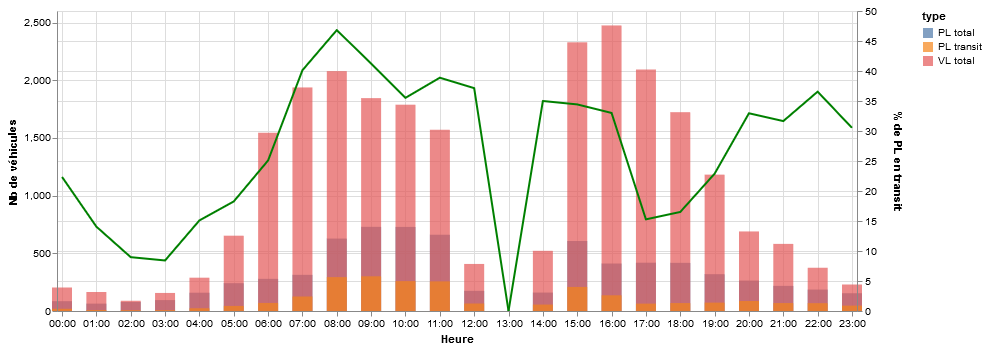

In [52]:
#penser à filtrer les données selon les mêmes jours que pour les pivot table
g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam, '2019-01-29', 4)

## 7.2 Redressement au niveau de la Rocade

In [126]:
#determiner les passages fictifs
df_passage_transit_redresse, df_pl_redresse, trajets_rocade_non_vu=t.passages_fictif_rocade (t.liste_trajet_rocade, dico_od_final,dico_passag_final,df_pl)
#regrouper
%time synt_nb_veh_cam_redresse=t.pourcentage_pl_camera(df_pl_redresse,df_passage_transit_redresse, df_vl)

pl_tot =1920 , vl_tot=1920 , pl_transit=1262,pl_tot-joint-transit=1262
Wall time: 1.3 s


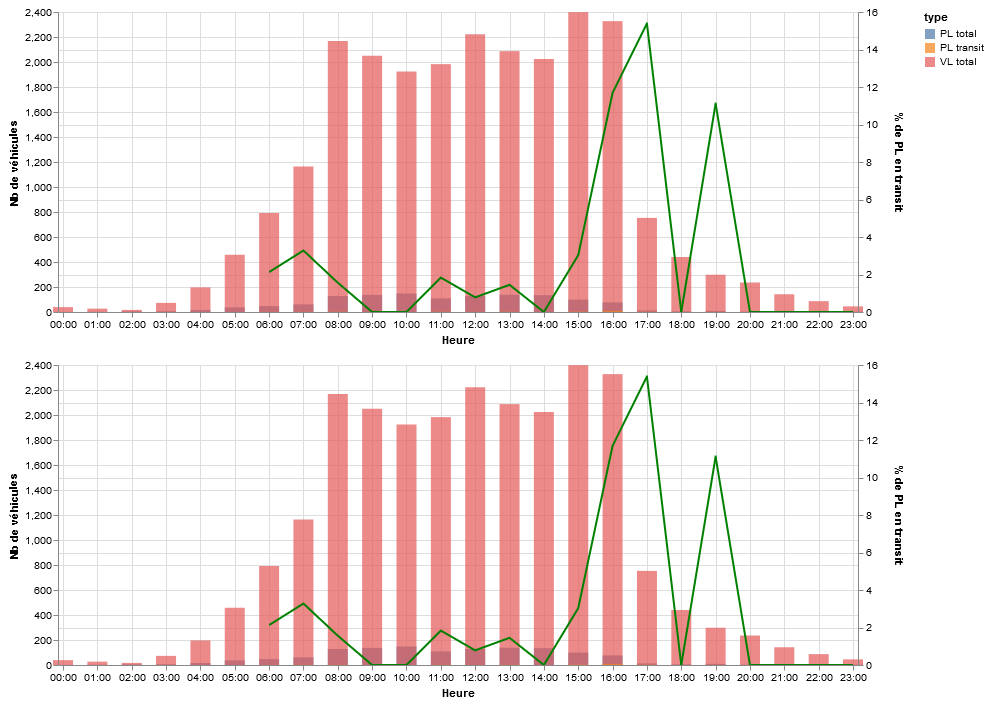

In [46]:
alt.vconcat(g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam, '2019-01-28', 1),g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam_redresse, '2019-01-28', 1))

## 7.3 Redressement des trajets extrapoles

>**A TESTER SUR JEU DE DONNEES COMPLET**

In [ ]:
# de même que opur la rocade, il faut ajouter des passages fictifs à la df des passages afin de pouvoir approximer mieux les parts de PL
#trouver les passages extrapoles
df_od_final.loc[df_od_final['correction_o_d_type']=='extrapole']
# tester la camera de debut :si c'est pas une des cameras d'entree - sortie du dispositif, on sait si le trajet est extrapole en début ou fin
#selon l'o_d crééer un passage fictuf avec le numero de la camera qui manque du trajets sensé avoir eu leiu
#estimer le temps de passage selon le temps theorique : date_cam_1 ou 2 +ou- temps ou temps theorique

## 7.4. Grouper les réusltats par JO

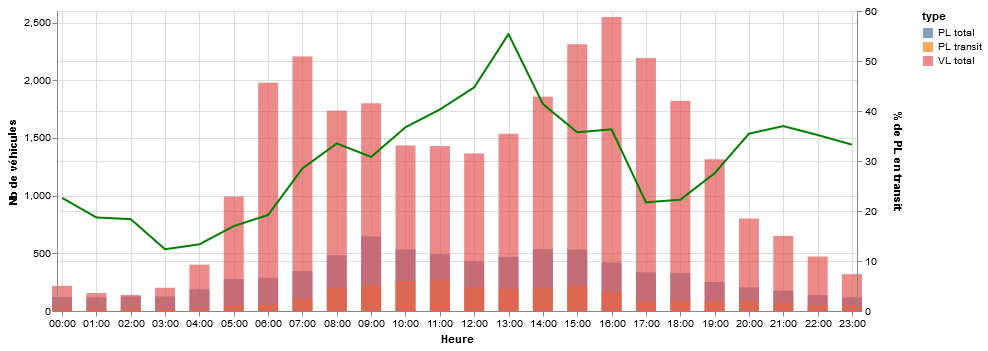

In [133]:
g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam_redresse, 'JO', 4)

# 8. Temps de parcours

In [26]:
# on cherche à obtenir le temps de parcours moyen pour une camera, sur un jour ou les jours ouvres, par o_d
# on construit donc une df avec : immat, cam, tps_parcours, heure_Rocade
# pour l'heure à la Rocade : on va cehrcher dans les df_passage le passage:qui a la mm immat, dont la cam est 1,2,3,4 et dont le created est compris entre date_cam1et date_cam2

#isoler les passages concernes par la Rocade
passage_rocade=dico_passag_final.loc[(dico_passag_final['camera_id'].isin([1,2,3,4]))]# & (dico_passag_final['correction_o_d']==False)]

In [36]:
#jointure entre les o_d et les passages
o_d_joint_rocade=dico_od_final.merge(passage_rocade, on='immat', how='left')

In [109]:
#limiter les o_d là ou date du passages est ciompris entre les date 1 et date 2 de l'o_d
dico_od_Rocade_final=o_d_joint_rocade.loc[(o_d_joint_rocade['date_cam_1']<o_d_joint_rocade['created']) & 
                                          (o_d_joint_rocade['created']<o_d_joint_rocade['date_cam_2']) & 
                                          (o_d_joint_rocade['tps_parcours']<pd.Timedelta('4H'))]

In [155]:
#limiter les 
limite_donnees=dico_od_Rocade_final[['date_cam_1','immat','o_d','tps_parcours','created']].rename(columns={'created':'h_rocade'})

In [181]:
#filtrer selon une date ou des jours ouvrés ou mardi/jeudi : 
"""filtre_donnees=limite_donnees.loc[(limite_donnees.apply(lambda x : x['h_rocade'].dayofyear==pd.to_datetime('2019-01-28').dayofyear,axis=1)) & 
                          (pour_graph['o_d']=='A10-A62')].copy()"""
filtre_donnees=limite_donnees.loc[(limite_donnees.set_index('h_rocade').index.dayofweek<5) & 
                          (limite_donnees['o_d']=='A10-A63')].copy()
"""filtre_donnees=limite_donnees.loc[(limite_donnees.set_index('h_rocade').index.dayofweek.isin([1,3])) & 
                          (limite_donnees['o_d']=='A10-A62')].copy()"""

"filtre_donnees=limite_donnees.loc[(limite_donnees.set_index('h_rocade').index.dayofweek.isin([1,3])) & \n                          (limite_donnees['o_d']=='A10-A62')].copy()"

In [182]:
#transformer les valeur de temps en integer pour agregation
filtre_donnees['tps_parcours2']=filtre_donnees['tps_parcours'].values.astype(np.int64)

In [183]:
#mise en forme pour graph
groupe_h=filtre_donnees.set_index('h_rocade').resample('15T')['tps_parcours2'].mean()
#groupe_h['tps_parcours']=pd.to_timedelta(groupe_h['tps_parcours'])
groupe_h=pd.to_timedelta(groupe_h)
pour_graph=groupe_h.reset_index()
pour_graph['tps_parcours2']=pd.to_datetime('2019-01-31')+pour_graph['tps_parcours2']

In [185]:
pour_graph

h_rocade                 tps_parcours2
0   2019-01-28 01:30:00 2019-01-31 01:27:18.000000000
1   2019-01-28 01:45:00                           NaT
2   2019-01-28 02:00:00                           NaT
3   2019-01-28 02:15:00 2019-01-31 01:35:16.000000000
4   2019-01-28 02:30:00                           NaT
5   2019-01-28 02:45:00 2019-01-31 01:11:47.000000000
6   2019-01-28 03:00:00 2019-01-31 01:38:07.000000000
7   2019-01-28 03:15:00                           NaT
8   2019-01-28 03:30:00                           NaT
9   2019-01-28 03:45:00                           NaT
10  2019-01-28 04:00:00 2019-01-31 01:31:45.000000000
11  2019-01-28 04:15:00 2019-01-31 01:15:24.000000000
12  2019-01-28 04:30:00 2019-01-31 01:21:46.500000000
13  2019-01-28 04:45:00                           NaT
14  2019-01-28 05:00:00 2019-01-31 01:56:48.000000000
15  2019-01-28 05:15:00 2019-01-31 01:27:04.000000000
16  2019-01-28 05:30:00                           NaT
17  2019-01-28 05:45:00 2019-01-31 01:46:29.000000000
18  2019-01-28 06:00:00                           NaT
19  2019-01-28 06:15:00 2019-01-31 02:11:49.000000000
20  2019-01-28 06:30:00                           NaT
21  2019-01-28 06:45:00                           NaT
22  2019-01-28 07:00:00                           NaT
23  2019-01-28 07:15:00 2019-01-31 03:39:38.000000000
24  2019-01-28 07:30:00                           NaT
25  2019-01-28 07:45:00                           NaT
26  2019-01-28 08:00:00                           NaT
27  2019-01-28 08:15:00                           NaT
28  2019-01-28 08:30:00 2019-01-31 01:55:37.166666666
29  2019-01-28 08:45:00 2019-01-31 01:28:53.000000000
..                  ...                           ...
638 2019-02-03 17:00:00                           NaT
639 2019-02-03 17:15:00                           NaT
640 2019-02-03 17:30:00                           NaT
641 2019-02-03 17:45:00                           NaT
642 2019-02-03 18:00:00                           NaT
643 2019-02-03 18:15:00                           NaT
644 2019-02-03 18:30:00                           NaT
645 2019-02-03 18:45:00                           NaT
646 2019-02-03 19:00:00                           NaT
647 2019-02-03 19:15:00                           NaT
648 2019-02-03 19:30:00                           NaT
649 2019-02-03 19:45:00                           NaT
650 2019-02-03 20:00:00                           NaT
651 2019-02-03 20:15:00                           NaT
652 2019-02-03 20:30:00                           NaT
653 2019-02-03 20:45:00                           NaT
654 2019-02-03 21:00:00                           NaT
655 2019-02-03 21:15:00                           NaT
656 2019-02-03 21:30:00                           NaT
657 2019-02-03 21:45:00                           NaT
658 2019-02-03 22:00:00                           NaT
659 2019-02-03 22:15:00                           NaT
660 2019-02-03 22:30:00                           NaT
661 2019-02-03 22:45:00                           NaT
662 2019-02-03 23:00:00                           NaT
663 2019-02-03 23:15:00                           NaT
664 2019-02-03 23:30:00                           NaT
665 2019-02-03 23:45:00                           NaT
666 2019-02-04 00:00:00 2019-01-31 01:55:23.000000000
667 2019-02-04 00:15:00 2019-01-31 01:31:24.500000000

[668 rows x 2 columns]

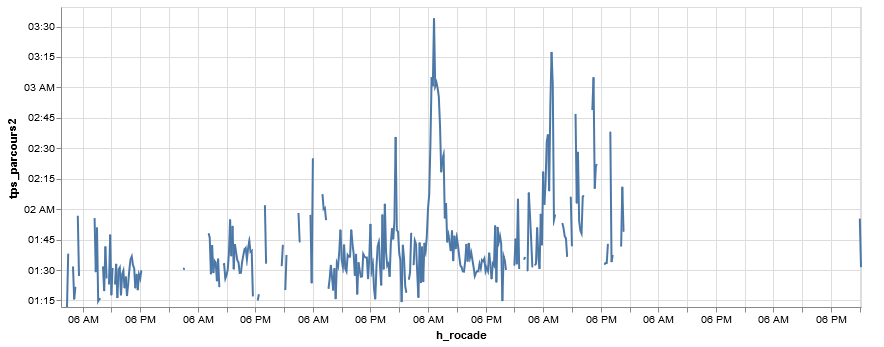

In [184]:
alt.Chart(pour_graph).mark_line().encode(
    x='h_rocade:T',
    y='tps_parcours2').properties(width=800)

In [ ]:
dico_od_final.loc[(dico_od_final['o_d']=='A10-A62') & (dico_od_final['date_cam_1']>pd.to_datetime('2019-01-28 21:00'))].sort_values('date_cam_1')

In [559]:
test=t.trajet(df_passages6.loc['2019-01-31 00:00:00':'2019-02-01 23:59:59'], '2019-01-31 08:15:00', 15, [8, 13],typeTrajet='Global',temps_max_autorise=18)

In [547]:
param_cluster=pd.read_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\param_cluster.json', orient='index')

In [563]:
visu=t.jointure_temps_reel_theorique(test.df_transit,dixco_tpsmax_corrige,t.liste_complete_trajet, 15)

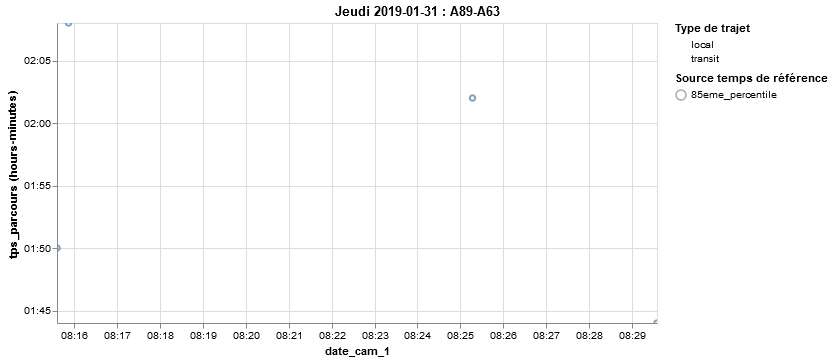

In [564]:
g.graph_transit_filtre(visu,'2019-01-31 00:00:00','2019-01-31 23:59:59','A89-A63')

# CORRIGER LES TEMPS DE PARCOURS LIMITES

In [162]:
#isoler les données : sur un jour pour une o_d
o_d='A10-A63'
date='2019-01-23'
test_predict=dico_df_transit['df_transit_marge0'].loc[(dico_df_transit['df_transit_marge0']['o_d']==o_d) &
             (dico_df_transit['df_transit_marge0'].set_index('date_cam_1').index.dayofyear==pd.to_datetime(date).dayofyear)].copy()

In [163]:
#ajouter des champsde ocnversion des dates en integer, limiter les valeusr sinon pb de mémoire avec sklearn
test_predict['date_int']=((test_predict.date_cam_1 - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))/1000000
test_predict['temps_int']=(((pd.to_datetime('2018-01-01')+test_predict.tps_parcours) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))/1000000

In [1074]:
#créer les données d'entrée du modele
X=np.array([[a,b] for a,b in zip(test_predict.date_int.tolist(),test_predict.temps_int.tolist())])
y=np.array(test_predict.filtre_tps.tolist())

In [1075]:
#créer le modele
ga=1000
C=35
clf = svm.SVC(kernel='rbf', gamma=ga, C=C)

In [1076]:
#alimenter le modele
clf.fit(liste_nsample_nfeat, n_sample)

SVC(C=35, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1000, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [1077]:
#isoler les donner à tester
df_a_tester=test_predict.loc[(test_predict['filtre_tps']==0) & (test_predict['type']=='85eme_percentile')].copy()

In [1078]:
#liste à tester
liste_a_tester=np.array([[a,b] for a,b in zip(df_a_tester.date_int.tolist(),df_a_tester.temps_int.tolist())])
#dfde résultats de prédiction
df_type_predit=pd.DataFrame([[i, v] for i,v in zip(df_a_tester.index.tolist(),[clf.predict([x])[0] for x in liste_a_tester])], 
                            columns=['index_source','type_predit'])
#mise à jourde la df source
df_transit_avec_filtre.loc[df_transit_avec_filtre.index.isin(df_type_predit.index_source.tolist()),'type']='predit'
df_transit_avec_filtre.loc[df_transit_avec_filtre.index.isin(df_type_predit.loc[df_type_predit['type_predit']==1].index_source.tolist()),'filtre_tps']=1

In [1172]:
df_transit_avec_filtre.loc[df_transit_avec_filtre['type']=='predit']

Empty DataFrame
Columns: [date_cam_1, immat, l, state, id, date_cam_2, cameras, origine, destination, o_d, tps_parcours, period, date, temps, type, tps_parcours_theoriq, filtre_tps]
Index: []

Wall time: 1.69 s


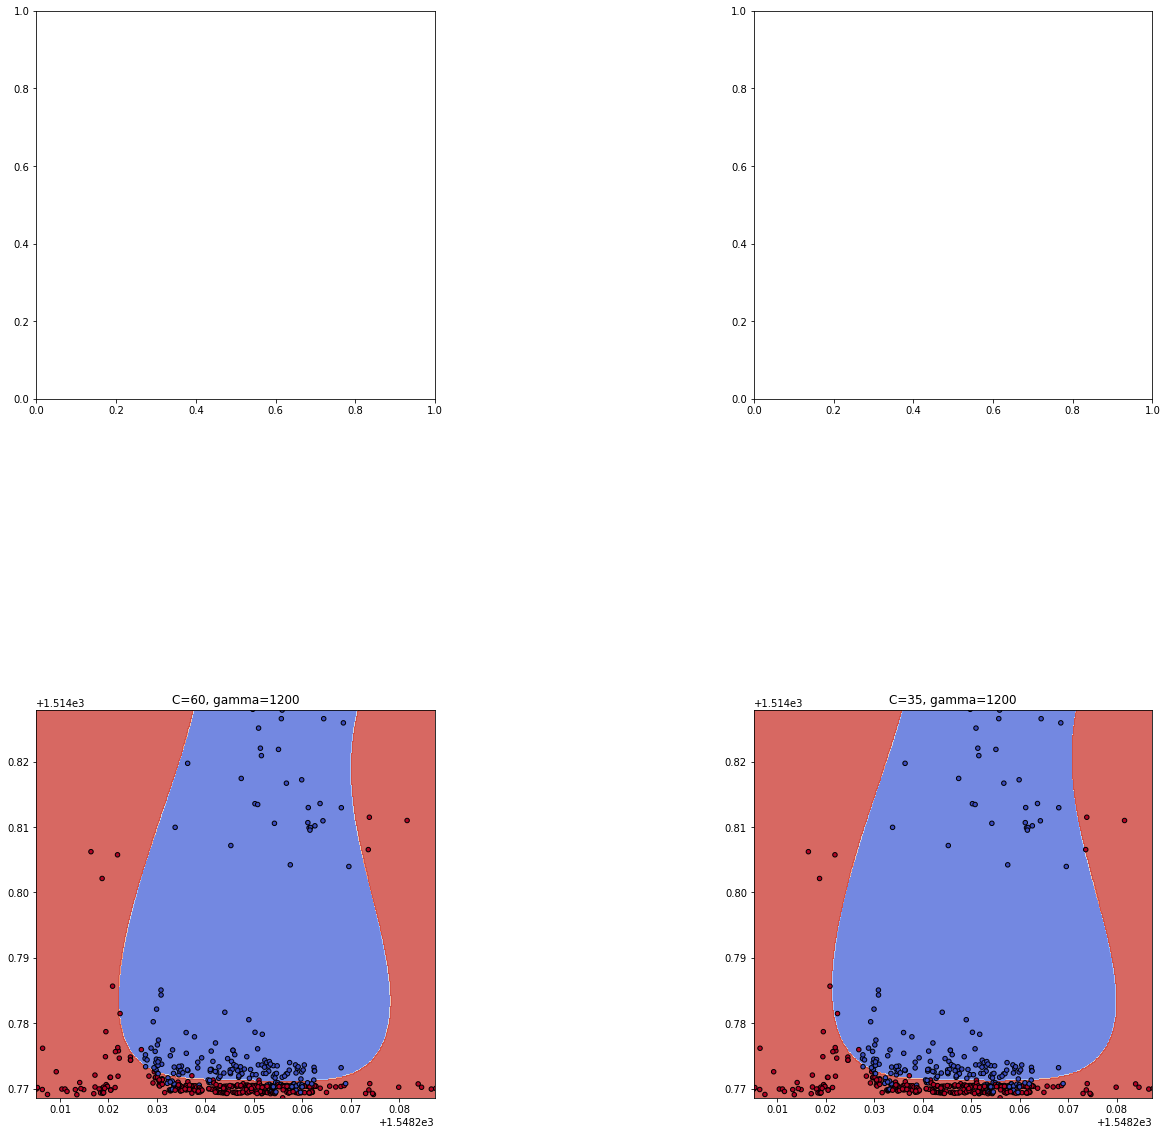

In [166]:
%%time
def make_meshgrid(x, y, h=.0002):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 0.000000001, x.max() + 0.000000001
    y_min, y_max = y.min() - 0.000000001, y.max() + 0.000000001
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

X=np.array([[a,b] for a,b in zip(test_predict.date_int.tolist(),test_predict.temps_int.tolist())])
y=np.array(test_predict.filtre_tps.tolist())
#C = 25# SVM regularization parameter
models = (svm.SVC(kernel='rbf', gamma=600, C=70),
         svm.SVC(kernel='rbf', gamma=600, C=35),
         svm.SVC(kernel='rbf', gamma=500, C=100),
         svm.SVC(kernel='rbf', gamma=500, C=200))
models = (clf.fit(X, y) for clf in models)


# Set-up 2x2 grid for plotting.
fig, sub = plt.figure(figsize=(20,20)).subplots(2,2)
plt.subplots_adjust(wspace=0.8, hspace=0.8)

# title for the plots
titles = ('C=60, gamma=1200',
          'C=35, gamma=1200',
          'C=100, gamma=500',
          'C=200, gamma=500')

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)

#plt.show()
plt.savefig(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Projet Rapport\illustrations\impact_prediction_A10-A63.png')

In [ ]:
liste_od_ok=['A660-A62','A62-A63','A63-A62','A62-A10','A660-N10', 'A660-A10','N10-A63','A62-N10']
for od in [x for x in df_transit_avec_filtre.o_d.unique().tolist() if x not in liste_od_ok ] : 
    for date in set([a[0].strftime('%Y-%m-%d') for a in t.creer_liste_date('2019-01-31',11)]):
        try : 
            df_transit_avec_filtre=t.predire_type_trajet(df_transit_avec_filtre,od, date,600,35)
        except ValueError : 
            continue

# VERIF AFFECTATION CLUSTER

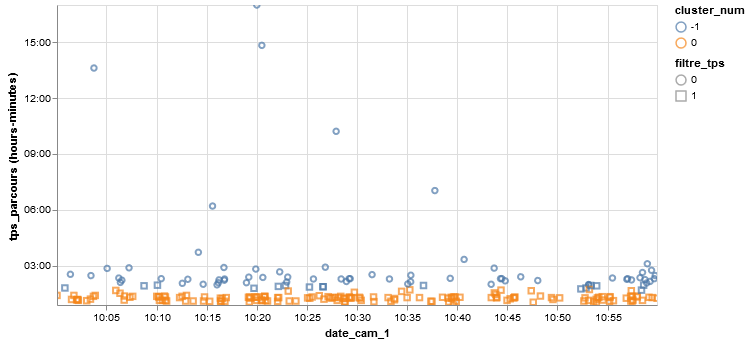

In [88]:
#test cluster
od='N10-A63'
date_debut='2019-01-23 10:00:00'
datefin='2019-01-23 11:00:00'
delai=1200
coeff=4
df_pl_ok=dico_df_transit['df_transit_marge15'].loc[(dico_df_transit['df_transit_marge15']['o_d']==od) &
                                   (dico_df_transit['df_transit_marge15']['date_cam_1'].between(pd.to_datetime(date_debut),pd.to_datetime(datefin)))]
donnees_src=df_pl_ok.loc[:,['date_cam_1','tps_parcours']].copy() #isoler les données necessaires
liste_valeur=donnees_src.tps_parcours.apply(lambda x : ((pd.to_datetime('2018-01-01')+x)-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).tolist()#convertir les temps en integer
liste_date=donnees_src.date_cam_1.apply(lambda x :(x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).tolist()
liste=[[liste_date[i],liste_valeur[i]] for i in range(len(liste_valeur))]
if len(liste_valeur)<5 : #si il n'y a pas bcp de pl on arrete ; pourraitfair l'objet d'un parametre
    raise ClusterError()
#faire tourner la clusterisation et recupérer le label (i.e l'identifiant cluster) et le nombre de cluster
clustering=DBSCAN(eps=delai, min_samples=len(liste_valeur)/coeff).fit(liste)

labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# A AMELIORER EN CREANT UNE ERREUR PERSONALISEE SI ON OBTIENT  CLUSTER
if n_clusters_== 0 :
    print('vlaueError')
#mettre en forme au format pandas
results = pd.DataFrame(pd.DataFrame([donnees_src.index,labels]).T)
results.columns = ['index_base', 'cluster_num']
results = pd.merge(results,df_pl_ok, left_on='index_base', right_index=True )
graph_results=results[['date_cam_1','tps_parcours','filtre_tps','cluster_num']].copy()
graph_results.tps_parcours=pd.to_datetime('2018-01-01')+graph_results.tps_parcours
alt.Chart(graph_results).mark_point().encode(
                                x='date_cam_1',
                                y='hoursminutes(tps_parcours)',
                                tooltip='hoursminutes(tps_parcours)',
                                color='cluster_num:N',
                                shape='filtre_tps:N').interactive().properties(width=600)

In [77]:
t.param_cluster

delai  nb_pt_min  temps_etudie  \
0    600          4            15   
1   1200          4            60   
2    800          3            15   
3   1000          4            60   
4   1000          4            15   

                                                                                                                      trajet  
0           [A10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]  
1  [A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]  
2  [A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]  
3  [A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]  
4                                                                                                                    N10-A63

In [99]:
{'toto'+str(i):i for i in [0,45,600]}

{'toto0': 0, 'toto45': 45, 'toto600': 600}

# TESTS

In [158]:
#mise à jour attribut drapeau de transit
df_transit_A63_final=t.identifier_transit(df_transit_A63_redresse_tstps, 45,'temps_filtre_cestas','tps_parcours_cestas')

In [172]:
#Mise à jour structure table et ajout attribut drapeau de correction
df_transit_A63_attr_ok=df_transit_A63_final.drop([attr_cestas for attr_cestas in df_transit_A63_final.columns.tolist() if attr_cestas[-7:]=='_cestas'],axis=1)
df_transit_A63_attr_ok.loc[df_transit_A63_attr_ok['filtre_tps']==1,'correction_o_d']=True
df_transit_A63_attr_ok.loc[df_transit_A63_attr_ok['filtre_tps']==0,'correction_o_d']=False
df_transit_A63_attr_ok['correction_o_d_type']=df_transit_A63_attr_ok.apply(lambda x : 'temps_cestas' if x['correction_o_d'] else 'autre',axis=1)

In [ ]:
#insertion dans le df des trajets de transit avec u attribut a part (come pour les trajets incomplets)

In [188]:
%time toto=t.correction_temps_cestas(df_transit_extrapole,df_passages_immat_ok,dixco_tpsmax_corrige)

Wall time: 1min 19s


In [99]:
pd.read_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\nb_jours_mesures.json',orient='index').pivot(
    index='origine', columns='destination',values='nb_jo').replace('NC',np.NaN)

destination   A10   A62   A63  A660   A89   N10
origine                                        
A10           NaN  15.0  16.0  16.0  15.0   NaN
A62          15.0   NaN  16.0  16.0  15.0  16.0
A63          14.0  14.0   NaN   NaN  14.0  15.0
A660         15.0  15.0   NaN   NaN  15.0  16.0
A89          14.0  14.0  15.0  15.0   NaN   NaN
N10           NaN  14.0  15.0  15.0   NaN   NaN

In [103]:
mat_od_tot_calcul/pd.read_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\nb_jours_mesures.json',orient='index').pivot(
    index='origine', columns='destination',values='nb_jo').replace('NC',np.NaN)

destination      A10      A62      A63     A660      A89      N10
origine                                                          
A10              NaN  398.133  778.312  113.062  22.1333      NaN
A62              407      NaN   49.875  64.1875  70.5333  456.125
A63          856.857  35.3571      NaN      NaN    212.5  3849.53
A660           104.8  57.8667      NaN      NaN  64.2667  321.688
A89          21.3571       69  269.733  86.1333      NaN      NaN
N10              NaN    340.5  3155.27    308.6      NaN      NaN

In [110]:
# filtre des dates selon les jours indisponible pour supprimer tout la journee
df_transit_jo=dico_df_od_final['df_od_final_marge45'].loc[dico_df_od_final['df_od_final_marge45'].apply(lambda x : 
not (x['cameras'][0]==6 and (x['date_cam_1'].day==pd.to_datetime('2019-01-29').day or x['date_cam_1'].day==pd.to_datetime('2019-01-30').day)) and 
not (x['cameras'][-1]==11 and x['date_cam_1'].day==pd.to_datetime('2019-02-01').day) and 
not (x['cameras'][-1]==9 and x['date_cam_1'].day==pd.to_datetime('2019-01-24').day) and
not (x['cameras'][0]==15 and x['date_cam_1'].day==pd.to_datetime('2019-01-31').day) and 
not (x['cameras'][-1]==7 and x['date_cam_1'].day==pd.to_datetime('2019-02-06').day) and 
not (x['cameras'][0]==8 and x['date_cam_1'].day==pd.to_datetime('2019-02-06').day),axis=1)]
#filtre des dates pour supprimer les WE
df_transit_jo=df_transit_jo.loc[df_transit_jo.set_index('date_cam_1').index.dayofweek<5]
#matrice_o_d jours ouvres
mat_o_d_jo=pd.pivot_table(df_transit_jo,values='l', index='origine', columns='destination',aggfunc='count')/t.matrice_nb_jo

In [111]:
#creation table pivot
pivot_od_jo_filtre=pd.pivot_table(df_transit_jo,values='l', index='origine', columns='destination',aggfunc='count')

In [144]:
dico_df_od_final['df_od_final_marge45']

date_cam_1      index                                     immat  \
0   2019-01-23 00:22:09  5839110.0  e8253b48cafa556d2bc4d077d97fa9dee507c3ee   
1   2019-01-23 07:00:53  5839794.0  cea88baff57f696aec98f4d6144b6e74774087b6   
2   2019-01-23 07:02:00  5896701.0  98bed73843d18e602e9fd0ef39ce72ffc0835874   
3   2019-01-23 07:02:33  5839798.0  cdd6113d27b891563b7e3ec7fb1e6ae70c3b28cd   
6   2019-01-23 07:05:11  5839805.0  131a1b876bbcd1e24d53bc25b4a1edd8bdfc9336   
8   2019-01-23 07:08:02  5839813.0  7fa1abefff9c6c8f3c68048cabcb17b5d254b9f5   
9   2019-01-23 07:08:15  5839814.0  7fcc6dd8812f703a7b374dee07b023b20b21e95a   
10  2019-01-23 07:11:40  5896713.0  1d9382b031944d041f2ca2a0b2e9ee577155fec1   
11  2019-01-23 07:16:21  5896720.0  632f37863b6aa984a928d24285c0f6dc9fbd0e47   
13  2019-01-23 07:17:17  5839845.0  bb473eb3463472986b99b9ea65aed8d777dea24d   
14  2019-01-23 07:18:42  5896723.0  90f3d98b39dc5b2670ade55e870bdb7a95f2432c   
15  2019-01-23 07:19:26  5896725.0  839c0cfb3576d5dcabb9a2d0299b5e2684f77b45   
17  2019-01-23 07:22:42  5896736.0  7fa70df2ef049c1c3d1668777c2f126868e8cd1e   
19  2019-01-23 07:25:41  5839857.0  f4ef618072b7ea5f1418f5db932766d9603c5fa0   
22  2019-01-23 07:33:03  5839878.0  b130d856649808574e7546bb348c737fd0c43cc6   
23  2019-01-23 07:36:43  5896758.0  9eb048b3f10a7a1f71666de58605dfb3521bd522   
24  2019-01-23 07:38:21  5839896.0  5f45579a3b36d50f9bf4e9142ea3f647fe2cda6c   
25  2019-01-23 07:38:26  5896763.0  14f759bee4409c77dfe56d4b7e0425e7a124e731   
26  2019-01-23 07:40:52  5839902.0  f50ca2e03bc27927aa54fd37e03075d742c748cd   
27  2019-01-23 07:41:49  5839906.0  cdec9a5304a39608011f2a2f16bc28d6fbe8a1a9   
28  2019-01-23 07:45:12  5896772.0  e26e1f4b93eddc0606eb4ba427270bed85962e54   
29  2019-01-23 07:46:58  5839917.0  70535287f78f10f8f0bca3ebf88fbb6b1f0bc210   
30  2019-02-02 20:42:57  5914418.0  70535287f78f10f8f0bca3ebf88fbb6b1f0bc210   
31  2019-01-23 07:47:36  5839919.0  a31c2a659c1aee502bcfa30ace71ddd3c6beeb39   
32  2019-02-13 07:53:12  7672989.0  a31c2a659c1aee502bcfa30ace71ddd3c6beeb39   
33  2019-01-23 07:48:22  5839921.0  adc53a2e0508d24bda5ce7ff87ebd8c27bc8fbb5   
35  2019-01-23 08:01:40  5896805.0  5e987ebcbf4d37ee0caa5b5a9ab8c47b1170b1ea   
36  2019-01-23 08:02:09  5839966.0  fcadc2d6d7b23e1bf7609f29e33051d4e9da1127   
37  2019-01-23 08:03:50  5839972.0  74e35e59edf256a70ab7c00654d139bcb6a458d7   
38  2019-01-23 08:05:11  5839978.0  0d8cc532fa694e8abfbb48fdef9f66783587f576   
..                  ...        ...                                       ...   
940 2019-01-25 04:41:36        NaN  4ca32370f282e53366542a8abb7c9ac808d87dc8   
941 2019-01-25 07:59:41        NaN  edad0bdff6a6e0fa4d0c280ea2b650205e123c36   
943 2019-01-28 14:34:26        NaN  ea9caed7abb17320c2c86bc4f10c94d5399537fe   
944 2019-02-05 23:59:55        NaN  d1da6c6d0d0d3cb351157b5de108d5a9aa4a3d25   
945 2019-02-06 02:07:29        NaN  9a5428b4f6ccf97b52c82b05f3fd17da93ffb9ca   
946 2019-01-23 12:44:02        NaN  1a46998684ebaf4cc56b2f1701987e387c6fd202   
947 2019-01-23 14:31:52        NaN  9d0764810b4baa0edb8e778c004adbc6a35680ac   
948 2019-01-23 17:07:00        NaN  6395a9514049d38092ad7ad6199a7bf4dca5383c   
950 2019-01-28 10:17:45        NaN  725456575e72269a2659761b613258e26b50f802   
951 2019-01-28 16:12:53        NaN  dd97f4e2b22c23616293f2c06c9c112684bda969   
952 2019-01-29 15:19:48        NaN  7b5a8fcf550e00f06607fead76636311eee81ed9   
953 2019-01-29 16:21:49        NaN  5c67ea0194e53986567bfb2a44c9f9b5152bda43   
954 2019-01-30 15:48:10        NaN  fc51c5c5d760a21d8c3cedea922d7b228db68944   
955 2019-02-08 15:45:01        NaN  8e18448049cce198666e28304c16a3a5e8a37ccd   
956 2019-01-23 13:02:12        NaN  5a13ccb5687a36813c9859b041884822a3c218e3   
957 2019-01-23 17:27:48        NaN  b0b037d0bc24c0c7f3a517e1b4145348e40eeaae   
958 2019-01-25 07:06:37        NaN  c4196c4d3c9e83abd409a4cf20a121fea597ad3f   
960 2019-01-25 20:18:25        NaN  fd6630fddd8d51d99303e8ba64231bcfdd4517d8   
961 2019-01-2